In [1]:
import os
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.optimize import brentq

# === 1. Create output directories ===
output_folder_common = Path("output_common")
output_folder_speed = Path("output_speed_based")
output_folder_other = Path("output_other_features")
output_folder_common.mkdir(exist_ok=True)
output_folder_speed.mkdir(exist_ok=True)
output_folder_other.mkdir(exist_ok=True)

# === 2. Load & clean data ===
df = pd.read_csv("main dataset.csv")
df = df.dropna(subset=['crash_rate_per_km'])
osm_ids = df['osm_id']
df = df.drop(columns=['city','osm_id','name'])

# === 3. Bin rare categories for high-cardinality 'surface' ===
bin_cols = ['surface']
threshold = 5
for col in bin_cols:
    freqs = df[col].value_counts()
    df[col] = df[col].where(freqs[df[col]] >= threshold, 'other')

# === 4. Feature engineering ===
# Interaction terms
df['aadt_curv_interaction'] = df['aadt'] * df['mean_curvature']
df['aadt_lanes_interaction'] = df['aadt'] * df['lanes']
df['aadt_length_interaction'] = df['aadt'] * df['segment_length_km']
df['aadt_speed'] = df['aadt'] * df['maxspeed']
df['aadt_pop_interaction'] = df['aadt'] * df['population']
df['lanes_length_interaction'] = df['lanes'] * df['segment_length_km']
df['lanes_speed_interaction'] = df['lanes'] * df['maxspeed']
df['curv_lanes_interaction'] = df['mean_curvature'] * df['lanes']

# Polynomial/nonlinear terms
df['maxspeed_sq'] = df['maxspeed'] ** 2
df['mean_curvature_sq'] = df['mean_curvature'] ** 2
df['aadt_sq'] = df['aadt'] ** 2
df['lanes_sq'] = df['lanes'] ** 2
df['segment_length_sq'] = df['segment_length_km'] ** 2

# Ratios/densities (protect against divide-by-zero)
df['aadt_per_lane'] = df['aadt'] / df['lanes'].replace(0, np.nan)
df['pop_density_per_length'] = df['population'] / df['segment_length_km'].replace(0, np.nan)
df['aadt_per_length'] = df['aadt'] / df['segment_length_km'].replace(0, np.nan)
df['crashes_per_pop'] = df['city_total_crashes'] / df['population'].replace(0, np.nan)
df['crashes_per_aadt'] = df['city_total_crashes'] / df['aadt'].replace(0, np.nan)

# Binary/categorical combinations (example: adjust according to your categories)
df['urban'] = (df['classification'].str.lower().str.contains('urban')).astype(int)
df['urban_high_aadt'] = ((df['urban'] == 1) & (df['aadt'] > df['aadt'].median())).astype(int)
df['bridge_high_speed'] = ((df['bridge'] == 1) & (df['maxspeed'] > df['maxspeed'].median())).astype(int)
df['tunnel_high_speed'] = ((df['tunnel'] == 1) & (df['maxspeed'] > df['maxspeed'].median())).astype(int)

# If you have 'sidewalk' and 'oneway' as binary
df['sidewalk_high_pop'] = ((df['sidewalk'] == 1) & (df['population'] > df['population'].median())).astype(int)
df['oneway_high_speed'] = ((df['oneway'] == 1) & (df['maxspeed'] > df['maxspeed'].median())).astype(int)

def attach_ids(df_part, ids):
    df_part = df_part.reset_index(drop=True)
    df_part['osm_id'] = ids.reset_index(drop=True)
    return df_part

# === 5. Train/test split ===
y_rate = df['crash_rate_per_km']
y_crashes = df['city_total_crashes']
X = df.drop(columns=['crash_rate_per_km','city_total_crashes','segment_length'])
a,b,c,d,e,f,g,h = train_test_split(
    X, y_rate, y_crashes, osm_ids,
    test_size=0.2, stratify=X['highway'], random_state=42
)
X_train, X_test, y_tr_rate, y_te_rate, y_tr_crash, y_te_crash, osm_tr, osm_te = (a,b,c,d,e,f,g,h)
X_train = attach_ids(X_train, osm_tr)
X_test = attach_ids(X_test, osm_te)
for y in [y_tr_rate, y_tr_crash, y_te_rate, y_te_crash]: y.reset_index(drop=True, inplace=True)

# observed speed bounds
s_min, s_max = df['maxspeed'].min(), df['maxspeed'].max()

# === 6. Preprocessing pipeline (minimal, robust against collinearity) ===

binary_cols = ['bridge', 'tunnel', 'lit', 'sidewalk', 'oneway', 'cycleway']

numeric_cols = [
    # Base features
    'lanes',
    'maxspeed',
    'segment_width',
    'mean_curvature',
    'aadt',
    'population',
    'segment_length_km',

  
    'aadt_curv_interaction',     
    'aadt_per_lane',              

    # Binary columns (as numeric)
    'bridge',
    'tunnel',
    'lit',
    'sidewalk',
    'oneway',
    'cycleway',
    'urban'
]
pre = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ['surface', 'highway', 'classification'])
], remainder='drop')

X_tr_p = pre.fit_transform(X_train)
X_te_p = pre.transform(X_test)
feat_names = np.concatenate([
    pre.named_transformers_['num'].get_feature_names_out(numeric_cols),
    pre.named_transformers_['cat'].get_feature_names_out(['surface', 'highway', 'classification'])
])

X_tr_df = pd.DataFrame(X_tr_p[:, :len(numeric_cols)], columns=numeric_cols)
print("Correlation matrix for numeric features:")
print(X_tr_df.corr())

# === 7. Zero-variance & VIF filtering ===
vt = VarianceThreshold(0.0)
sup = vt.fit(X_tr_p).get_support()
X_tr_v = X_tr_p[:, sup]
X_te_v = X_te_p[:, sup]
fv = feat_names[sup]
vifs = []
with np.errstate(divide='ignore', invalid='ignore'):
    for i in range(X_tr_v.shape[1]):
        try: vifs.append(variance_inflation_factor(X_tr_v, i))
        except:  vifs.append(np.inf)
vif_df = pd.DataFrame({'feature': fv, 'VIF': vifs})
# === Common output ===
vif_df.to_csv(output_folder_common/'vif_results.csv', index=False)
keep = vif_df[vif_df['VIF'] <= 5]['feature'].tolist()
must_include = ['maxspeed', 'maxspeed_sq', 'aadt_speed']
for f in must_include:
    if f in fv and f not in keep:
        keep.append(f)
keep_idx = [list(fv).index(f) for f in keep]
X_tr_f = X_tr_v[:, keep_idx]
X_te_f = X_te_v[:, keep_idx]

# === 8. Train Random Forest ===
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_tr_f, y_tr_rate)
rf_importances = pd.DataFrame({'feature':keep,'importance':rf.feature_importances_})\
  .sort_values('importance',ascending=False)
# === Common output ===
rf_importances.to_csv(output_folder_common/'rf_importances.csv',index=False)

# === 9. Train Poisson GLM ===
design = pd.DataFrame(X_tr_f,columns=keep,index=X_train.index)
design_c = sm.add_constant(design,has_constant='add')
offset = np.log(X_train['segment_length_km'])
pois_res = sm.GLM(y_tr_crash,design_c,sm.families.Poisson(),offset=offset).fit()
# === Common output ===
pd.DataFrame({'IRR':np.exp(pois_res.params)}).to_csv(output_folder_common/'poisson_irrs.csv')
with open(output_folder_common/'poisson_metrics.txt','w') as f: f.write(f"AIC:{pois_res.aic}\nDeviance:{pois_res.deviance}\n")

# === 10. Evaluate Random Forest ===
pred_rf = rf.predict(X_te_f)
with open(output_folder_common/'rf_metrics.txt','w') as f:
    f.write(f"MAE:{mean_absolute_error(y_te_rate,pred_rf)}\nRMSE:{root_mean_squared_error(y_te_rate,pred_rf)}\nR2:{r2_score(y_te_rate,pred_rf)}\n")
pd.Series(-cross_val_score(rf,np.vstack([X_tr_f,X_te_f]),np.hstack([y_tr_rate,y_te_rate]),cv=5,scoring='neg_root_mean_squared_error')).to_csv(output_folder_common/'rf_cv_rmse.csv',index=False)

# === 11. Diagnostics plots ===
plt.scatter(pred_rf,y_te_rate-pred_rf);plt.xlabel('Fitted');plt.ylabel('Residuals');plt.title('RF Resids vs Fitted');plt.savefig(output_folder_common/'rf_residuals.png');plt.clf()
pred_po = pois_res.predict(sm.add_constant(pd.DataFrame(X_te_f,columns=keep),has_constant='add'),offset=np.log(X_test['segment_length_km']))
plt.scatter(pred_po,y_te_crash-pred_po);plt.xlabel('Fitted');plt.ylabel('Residuals');plt.title('Poisson Resids vs Fitted');plt.savefig(output_folder_common/'poisson_residuals.png');plt.clf()

# === 12. Speed-based multi-target recommendations ===
reduction_percs = list(range(10,110,10))
all_recs = {f"rf_rec_{p}pct":[] for p in reduction_percs}
for idx,row in X_test.iterrows():
    static = pre.transform(pd.DataFrame([row]))[:,sup][:,keep_idx]
    base = rf.predict(static.reshape(1,-1))[0]
    for p in reduction_percs:
        target=(1-p/100)*base
        def f(s):
            tmp=row.copy();tmp['maxspeed']=s
            arr=pre.transform(pd.DataFrame([tmp]))[:,sup][:,keep_idx]
            return rf.predict(arr.reshape(1,-1))[0]-target
        try: rec=brentq(f,s_min,s_max)
        except: rec=np.nan
        all_recs[f"rf_rec_{p}pct"].append(rec)
rec_df = pd.DataFrame({
    'osm_id': X_test['osm_id'],
    'existing_maxspeed': X_test['maxspeed'],
    'highway': X_test['highway'],
    'classification': X_test['classification']
})
for p in reduction_percs:
    rec_df[f"rf_rec_{p}pct"] = all_recs[f"rf_rec_{p}pct"]
# === Speed-based output ===
rec_df.to_csv(output_folder_speed/'recommendations.csv', index=False)

# === 13. Speed-based comparative analysis ===
for p in reduction_percs:
    rec_df[f"gap_{p}pct"] = rec_df[f"rf_rec_{p}pct"] - rec_df['existing_maxspeed']
gap_summaries=[]
for p in reduction_percs:
    temp=rec_df[['highway','classification',f'gap_{p}pct']]
    agg=temp.groupby(['highway','classification'])[f'gap_{p}pct'].agg(
        mean_gap='mean',median_gap='median',
        pct_within_5=lambda x:(x.abs()<=5).mean(),
        pct_within_10=lambda x:(x.abs()<=10).mean()
    ).reset_index()
    agg['reduction_pct']=p
    gap_summaries.append(agg)
gap_summary_all=pd.concat(gap_summaries,ignore_index=True)
# === Speed-based output ===
gap_summary_all.to_csv(output_folder_speed/'gap_summary_all.csv',index=False)

# ===== POLICY-RELEVANT SENSITIVITY SCENARIOS =====
scenarios = {
    # AADT (traffic volume)
    'aadt_up_10': 1.10,         # +10% traffic
    'aadt_down_10': 0.90,       # -10% traffic
    'aadt_up_20': 1.20,         # +20% traffic
    'aadt_down_20': 0.80,       # -20% traffic

    # Curvature (road design)
    'curvature_up_10': 1.10,    # +10% more curvy
    'curvature_down_10': 0.90,  # -10% less curvy

    # Population (area densification)
    'population_up_10': 1.10,   # +10% pop
    'population_down_10': 0.90, # -10% pop

    # Lanes (infrastructure change, handled as int addition)
    'lanes_up_1': 1,            # +1 lane
    'lanes_down_1': -1,         # -1 lane

    # Speed limit (policy change)
    'maxspeed_up_10': 10,       # +10 kph
    'maxspeed_down_10': -10,    # -10 kph

    # Segment length (road works, splitting/merging)
    'segment_length_up_10': 1.10,
    'segment_length_down_10': 0.90,
}

# === 14. Speed-based sensitivity analysis ===
try:
    sa_list=[]
    for name, factor in scenarios.items():
        tmp = X_test.copy()
        # Apply the scenario
        if 'aadt' in name:
            tmp['aadt'] *= factor
        elif 'curvature' in name:
            tmp['mean_curvature'] *= factor
        elif 'population' in name:
            tmp['population'] *= factor
        elif 'segment_length' in name:
            tmp['segment_length_km'] *= factor
        elif name == 'lanes_up_1':
            tmp['lanes'] = tmp['lanes'] + 1
        elif name == 'lanes_down_1':
            tmp['lanes'] = np.maximum(tmp['lanes'] - 1, 1)
        elif name == 'maxspeed_up_10':
            tmp['maxspeed'] = tmp['maxspeed'] + 10
        elif name == 'maxspeed_down_10':
            tmp['maxspeed'] = np.maximum(tmp['maxspeed'] - 10, 10)

        # Recompute all feature-engineered columns affected by changes:
        tmp['aadt_curv_interaction'] = tmp['aadt'] * tmp['mean_curvature']
        tmp['aadt_lanes_interaction'] = tmp['aadt'] * tmp['lanes']
        tmp['aadt_length_interaction'] = tmp['aadt'] * tmp['segment_length_km']
        tmp['aadt_speed'] = tmp['aadt'] * tmp['maxspeed']
        tmp['aadt_pop_interaction'] = tmp['aadt'] * tmp['population']
        tmp['lanes_length_interaction'] = tmp['lanes'] * tmp['segment_length_km']
        tmp['lanes_speed_interaction'] = tmp['lanes'] * tmp['maxspeed']
        tmp['curv_lanes_interaction'] = tmp['mean_curvature'] * tmp['lanes']
        tmp['maxspeed_sq'] = tmp['maxspeed'] ** 2
        tmp['mean_curvature_sq'] = tmp['mean_curvature'] ** 2
        tmp['aadt_sq'] = tmp['aadt'] ** 2
        tmp['lanes_sq'] = tmp['lanes'] ** 2
        tmp['segment_length_sq'] = tmp['segment_length_km'] ** 2
        tmp['aadt_per_lane'] = tmp['aadt'] / tmp['lanes'].replace(0, np.nan)
        tmp['pop_density_per_length'] = tmp['population'] / tmp['segment_length_km'].replace(0, np.nan)
        tmp['aadt_per_length'] = tmp['aadt'] / tmp['segment_length_km'].replace(0, np.nan)
        tmp['urban'] = (tmp['classification'].str.lower().str.contains('urban')).astype(int)
        tmp['urban_high_aadt'] = ((tmp['urban'] == 1) & (tmp['aadt'] > tmp['aadt'].median())).astype(int)
        tmp['bridge_high_speed'] = ((tmp['bridge'] == 1) & (tmp['maxspeed'] > tmp['maxspeed'].median())).astype(int)
        tmp['tunnel_high_speed'] = ((tmp['tunnel'] == 1) & (tmp['maxspeed'] > tmp['maxspeed'].median())).astype(int)
        tmp['sidewalk_high_pop'] = ((tmp['sidewalk'] == 1) & (tmp['population'] > tmp['population'].median())).astype(int)
        tmp['oneway_high_speed'] = ((tmp['oneway'] == 1) & (tmp['maxspeed'] > tmp['maxspeed'].median())).astype(int)
        if 'crossings' in tmp.columns:
            tmp['crossings_per_km'] = tmp['crossings'] / tmp['segment_length_km'].replace(0, np.nan)

        # Now do the rest as before:
        static_all = pre.transform(tmp)[:,sup][:,keep_idx]
        base_all = rf.predict(static_all)
        for p in reduction_percs:
            target = 0.01*(100-p)*base_all
            recs = []
            for row, t in zip(tmp.to_dict('records'), target):
                def f(s):
                    trow = row.copy(); trow['maxspeed'] = s
                    arr = pre.transform(pd.DataFrame([trow]))[:,sup][:,keep_idx]
                    return rf.predict(arr.reshape(1,-1))[0] - t
                try:
                    recs.append(brentq(f,s_min,s_max))
                except:
                    recs.append(np.nan)
            sa_list.append(pd.DataFrame({
                'osm_id':X_test['osm_id'],'scenario':name,
                'reduction_pct':p,'rec':recs
            }))
    sa_df = pd.concat(sa_list,ignore_index=True)
    # === Speed-based output ===
    sa_df.to_csv(output_folder_speed/'sensitivity_analysis_all.csv',index=False)
except Exception as e:
    print("Sensitivity analysis not run:", e)


# === 15. Save models ===
with open(output_folder_common/'rf_model.pkl','wb') as f: pickle.dump(rf,f)
with open(output_folder_common/'poisson_model.pkl','wb') as f: pickle.dump(pois_res,f)

# === 16. Other-features-based recommendations and risk scoring ===
# Identify top 3 non-speed features
top_non_speed_features = rf_importances[
    ~rf_importances['feature'].str.contains('maxspeed')
]['feature'].head(3).tolist()
print("Top non-speed features:", top_non_speed_features)

# Risk scoring and flagging
scaler = MinMaxScaler()
X_test_scaled = X_test.copy()
X_test_scaled[[f + '_norm' for f in top_non_speed_features]] = scaler.fit_transform(X_test[top_non_speed_features])
X_test_scaled['composite_risk'] = X_test_scaled[[f + '_norm' for f in top_non_speed_features]].sum(axis=1)
X_test_scaled['priority'] = X_test_scaled['composite_risk'] > X_test_scaled['composite_risk'].quantile(0.9)

# Export segments with highest composite risk (non-speed-based)
X_test_scaled[['osm_id'] + top_non_speed_features + ['composite_risk', 'priority']].to_csv(
    output_folder_other/'high_risk_segments.csv', index=False)

# Also create recommendations as text, based on which feature is highest
def get_other_recommendation(row):
    best = np.argmax([row[f + '_norm'] for f in top_non_speed_features])
    if best == 0:
        return f"Intervene due to high {top_non_speed_features[0]}"
    elif best == 1:
        return f"Intervene due to high {top_non_speed_features[1]}"
    else:
        return f"Intervene due to high {top_non_speed_features[2]}"

X_test_scaled['other_feature_recommendation'] = X_test_scaled.apply(get_other_recommendation, axis=1)
X_test_scaled[['osm_id', 'composite_risk', 'priority', 'other_feature_recommendation']].to_csv(
    output_folder_other/'recommendations_by_other_features.csv', index=False)

print("Pipeline complete: common, speed-based, and other-features-based outputs generated.")

Correlation matrix for numeric features:
                          lanes  maxspeed  segment_width  mean_curvature  \
lanes                  1.000000  0.110883       0.098128       -0.067959   
maxspeed               0.110883  1.000000      -0.073075       -0.029008   
segment_width          0.098128 -0.073075       1.000000        0.184330   
mean_curvature        -0.067959 -0.029008       0.184330        1.000000   
aadt                  -0.002252  0.079794      -0.015605        0.008462   
population            -0.002442  0.003585      -0.010366        0.026646   
segment_length_km      0.062547  0.298931      -0.006342       -0.046662   
aadt_curv_interaction -0.046075  0.026141       0.121684        0.737683   
aadt_per_lane         -0.210182  0.049302      -0.013479        0.023727   
bridge                 0.080703  0.285781       0.252745       -0.086118   
tunnel                -0.000672  0.032416       0.142991       -0.026600   
lit                    0.172509 -0.146218      

<Figure size 640x480 with 0 Axes>

C:\Users\joaqu\AppData\Local\Temp\ipykernel_31232\4106781575.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='other_feature_recommendation', data=X_test_scaled, order=X_test_scaled['other_feature_recommendation'].value_counts().index, palette="mako")


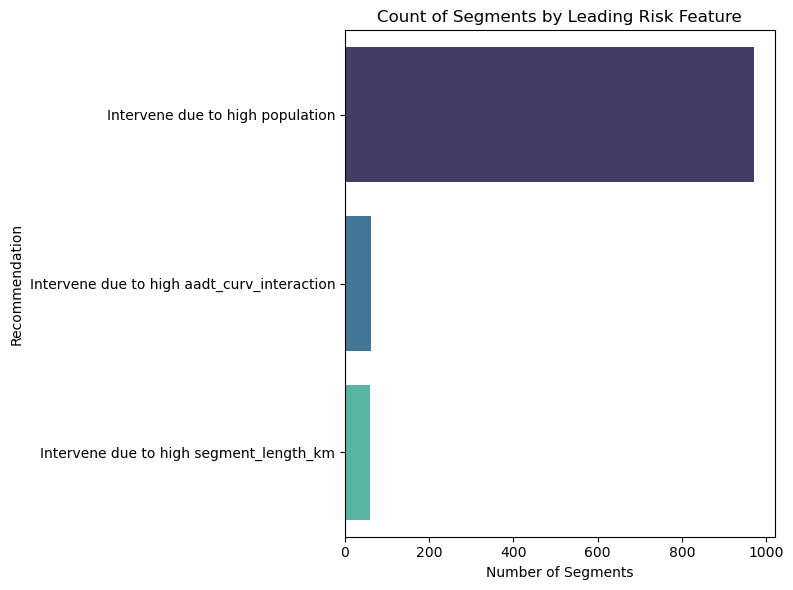